## Overview

Using [Gemma2_9b](https://huggingface.co/unsloth/gemma-2-9b-it-bnb-4bit) from unsloth team as base + LoRA adapter on top of it

using finetuned Gemma2 for multilingual tasks : https://huggingface.co/BAAI/bge-multilingual-gemma2  
-> A LLM-based multilingual embedding model, trained on a diverse range of languages and tasks. 

LoRA approximates model's weigths by factorising Q, K, V matrices into much smaller ones.  

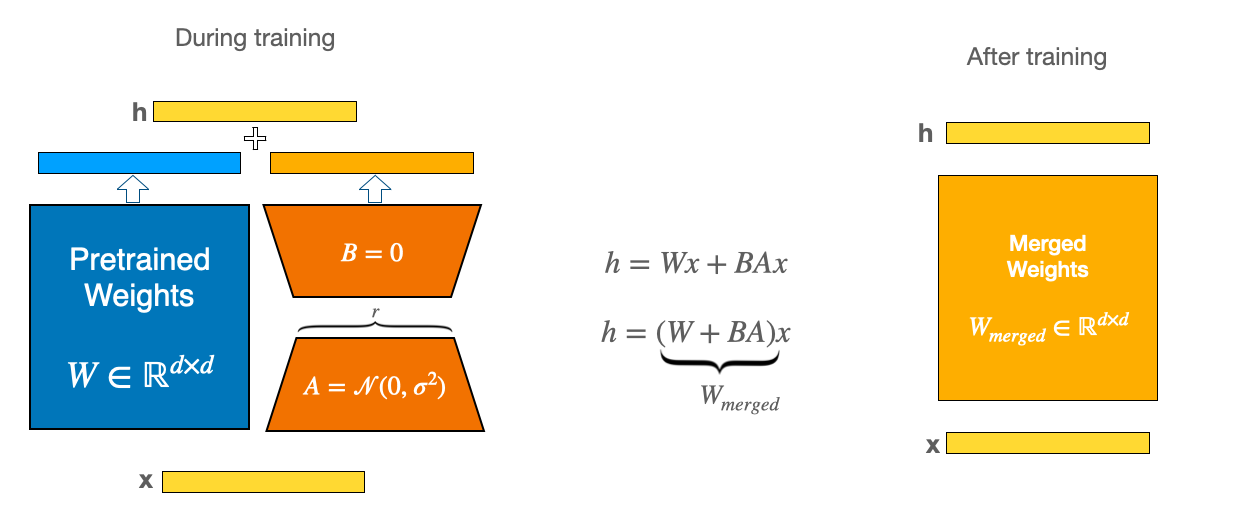  

Only those matrices will be updated during trainning -> reduce GPU memory usage. This is done with very little loss (casualities) on final metric.

> Note that QLoRA only quantize LLM's weights in low precision (e.g. 8-bit) while the computation of forward/backward are done in higher precision (e.g. 16-bit) and LoRA adapter's weights are also kept in higher precision.

HugginFace's Quantization Page : https://huggingface.co/docs/peft/developer_guides/quantization

Inspiration notebook https://www.kaggle.com/code/emiz6413/inference-gemma-2-9b-4-bit-qlora

Note : This will probably take a long time, i need to take some of mine to check for external compute resource for full trainning:
- RunPod : https://docs.runpod.io/tutorials/pods/run-fooocus
- Paperspace : https://www.paperspace.com/notebooks

## Imports

In [1]:
# gemma-2 is available from transformers>=4.42.3

import transformers as trsf
print("Transformers:", trsf.__version__)

#!pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft

Transformers: 4.46.3


In [2]:
import os
import copy
from dataclasses import dataclass
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

#from datasets import Dataset

from tqdm import tqdm

from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    Gemma2Model,
    GemmaTokenizerFast,
    Gemma2Config,
    AutoTokenizer,
    AutoModel,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import ModelsUtils as Utils
import Configurations as Configs
#import wsdm_modelutils as Utils

In [3]:
import peft as pft
print("Peft:", pft.__version__)

Peft: 0.14.0


In [4]:
print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


## Config

In [5]:
config_file = 'Configs.py'
manager = Configs.ConfigManager(config_file)

config = manager.micro
#config = manager.runpod_1
#load_from_config = manager.save_load_gemma2_2b_fp16
load_from_config = manager.save_load_gemma2_2b_fp16_hidden_512
config.config_name

'micro_gemma2_2b_fp16'

### Paths

In [6]:
# for AutoModel and auto tokenizer
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16'
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16-4bit'
base_model_path = config.basemodel_path


# peft pre saved locally
#peft_model_path = '/kaggle/input/peftchkpt_original/pytorch/default/1/'
peft_model_path = '../Checkpoints/'
checkpoint_name = "Original_notrain"

#df = pd.read_csv('/kaggle/input/wsdm-preprocessed-full-original/train_preprocessed_FULL_original.csv')
#dataframe_path = '/kaggle/input/train-preprocessed-mini-original/train_preprocessed_MINI_original.csv'
dataframe_path = config.train_data


## Trainning Args

In [7]:
#training_args = TrainingArguments(
#    output_dir="output",
#    overwrite_output_dir=True,
#    report_to="none",
#    num_train_epochs=config.n_epochs,
#    per_device_train_batch_size=config.train_batch,
#    gradient_accumulation_steps=config.gradient_accumulation_steps,
#    per_device_eval_batch_size=config.eval_batch,
#    logging_steps=10,
#    eval_strategy="epoch",
#    save_strategy="steps",
#    save_steps=200,
#    optim=config.optim_type,
#    fp16=True,
#    learning_rate=config.lr,
#    warmup_steps=config.warmup_steps,
#)

## LoRA Config

In [8]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj"],
    #layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.FEATURE_EXTRACTION, #SEQ_CLS
)

___________________________________________________________________________

## Data

In [9]:
df = pd.read_csv(dataframe_path)
df.head(1)

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label,prompt_len,response_a_len,response_b_len
0,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English,False,1,99,477,1799


In [10]:
df['prompt'] = df['prompt'].astype(str)
df['response_a'] = df['response_a'].astype(str)
df['response_b'] = df['response_b'].astype(str)

## Tokenize

In [11]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.add_eos_token = True      # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [12]:
df = df.sample(frac=config.sample_size, random_state=config.random_seed)

In [13]:
df.shape

(252, 13)

## Split

In [14]:
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=config.random_seed)

## Data Loader

In [15]:
# Prepare dataset and dataloader
dataset_train = Utils.ChatbotArenaDataset(df_train, tokenizer, max_length=config.max_length)
dataloader_train = Utils.DataLoader(dataset_train, batch_size=config.train_batch, shuffle=True)

dataset_valid = Utils.ChatbotArenaDataset(df_valid, tokenizer, max_length=config.max_length)
dataloader_valid = Utils.DataLoader(dataset_valid, batch_size=config.eval_batch, shuffle=True)

## Model

In [16]:
predictionModel = Utils.custom_load_model_chkpt(
                        config,
                        loadFrom=load_from_config,
                        checkpointName="Original_notrain",
                        device=device
                        )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
predictionModel

PreferencePredictionModel(
  (gemma_model): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
 

In [18]:
optimizer = optim.AdamW([
    {'params': predictionModel.gemma_model.parameters(), 'lr': 2e-6},     # Lower learning rate for transformer layers
    {'params': predictionModel.classifier.parameters(), 'lr': 1e-3},      # Higher learning rate for custom layers
], weight_decay=0.01)

#optimizer = optim.AdamW(predictionModel.parameters(), weight_decay=0.01)
#optimizer = optim.Adam(predictionModel.parameters())

## Train

In [19]:
predictionModel.gemma_model.config.hidden_size

2304

In [20]:
history = Utils.train_model(predictionModel, dataloader_train, dataloader_valid, optimizer, config, scheduler=None, device=device)

  0%|          | 0/113 [00:00<?, ?row/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
f:\Projects\Kaggle\2_WSDMCup_Multilingual_Chatbot_Arena\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|██████████| 13/13 [00:03<00:00,  3.26row/s]


Epoch 1 Finished
Accumulated Train Loss: 0.7021494291524971
Accumulated Train Accuracy: 0.5088495575221239
Valid Loss: 0.6871774976070111, Valid Accuracy : 0.5
0.6871774976070111 val loss is better than previous inf, saving checkpoint, epoch:  1
-----------------------------------------------------------------


100%|██████████| 13/13 [00:04<00:00,  3.25row/s]


Epoch 2 Finished
Accumulated Train Loss: 0.6846459945746227
Accumulated Train Accuracy: 0.5442477876106194
Valid Loss: 0.6724190161778376, Valid Accuracy : 0.5384615384615384
0.6724190161778376 val loss is better than previous 0.6871774976070111, saving checkpoint, epoch:  2
-----------------------------------------------------------------


100%|██████████| 13/13 [00:04<00:00,  3.24row/s]


Epoch 3 Finished
Accumulated Train Loss: 0.6668238544886091
Accumulated Train Accuracy: 0.5929203539823009
Valid Loss: 0.645662234379695, Valid Accuracy : 0.6153846153846154
0.645662234379695 val loss is better than previous 0.6724190161778376, saving checkpoint, epoch:  3
-----------------------------------------------------------------


100%|██████████| 13/13 [00:04<00:00,  3.25row/s]


Epoch 4 Finished
Accumulated Train Loss: 0.6048768985587939
Accumulated Train Accuracy: 0.7035398230088495
Valid Loss: 0.5899702104238363, Valid Accuracy : 0.6923076923076923
0.5899702104238363 val loss is better than previous 0.645662234379695, saving checkpoint, epoch:  4
-----------------------------------------------------------------


100%|██████████| 13/13 [00:04<00:00,  3.23row/s]


Epoch 5 Finished
Accumulated Train Loss: 0.5058850587996762
Accumulated Train Accuracy: 0.7831858407079646
Valid Loss: 0.5452916576312139, Valid Accuracy : 0.7307692307692307
0.5452916576312139 val loss is better than previous 0.5899702104238363, saving checkpoint, epoch:  5
-----------------------------------------------------------------


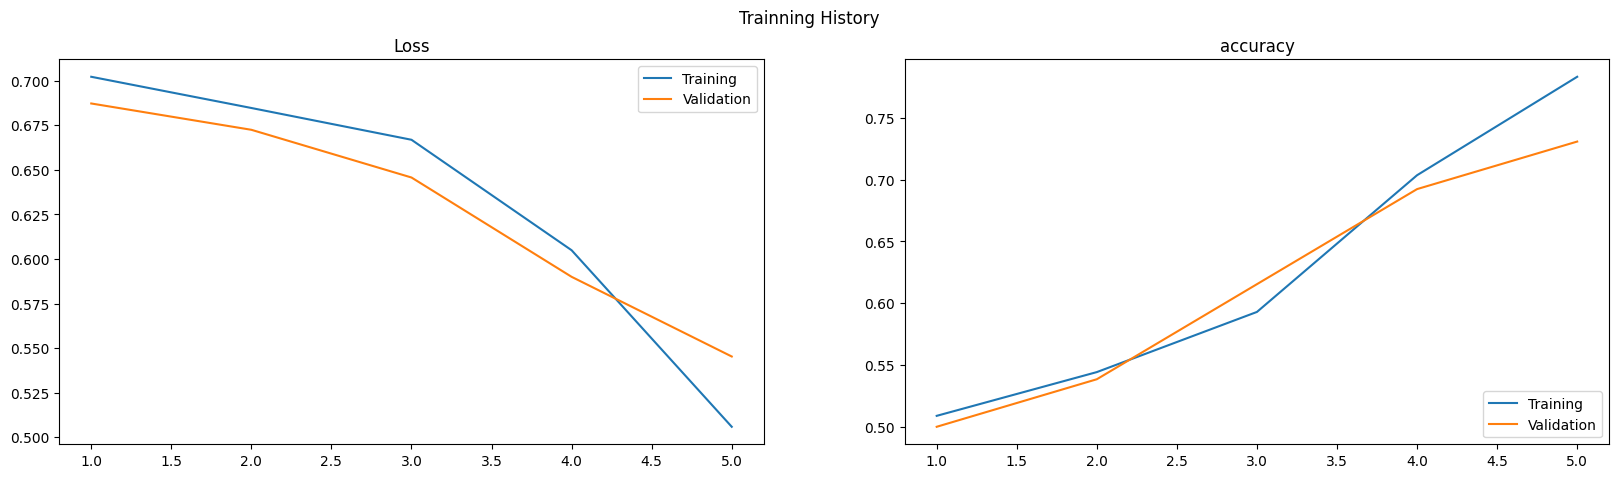

In [21]:
Utils.plot_model_history(history, "Trainning History")

In [22]:
#!runpodctl remove pod $RUNPOD_POD_ID